# Confounding Example: Finding causal effects from observed data

Suppose you are given some data with treatment and outcome. Can you determine whether the treatment causes the outcome, or the correlation is purely due to another common cause?

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)

## Let's create a mystery dataset for which we need to determine whether there is a causal effect.

Creating the dataset. It is generated from either one of two models:
* **Model 1**: Treatment does cause outcome. 
* **Model 2**: Treatment does not cause outcome. All observed correlation is due to a common cause.

In [3]:
rvar = 1 if np.random.uniform() >0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar, 
                                      num_common_causes=1, 
                                      sd_error=0.2)                                               
df = data_dict['df']                                                                                 
print(df[["Action", "Outcome", "w0"]].head())
                                                                                                                                                                                                         

      Action    Outcome        w0
0  10.397124  19.907319  3.951950
1   9.705589  19.528823  3.755365
2   7.013599  14.146836  1.205613
3   8.661421  17.994518  3.021639
4   3.091122   5.742650 -3.170280


No handles with labels found to put in legend.


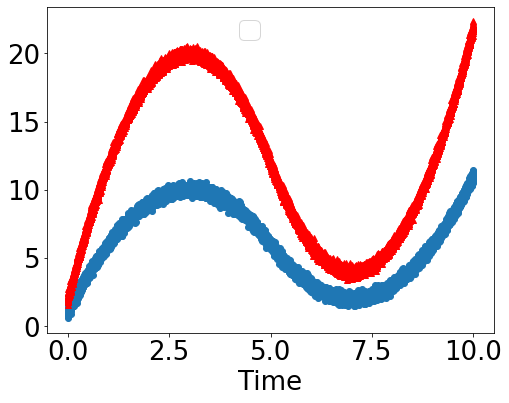

In [4]:
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])                                                       

## Using DoWhy to resolve the mystery: *Does Treatment cause Outcome?*
### STEP 1: Model the problem as a causal graph
Initializing the causal model.

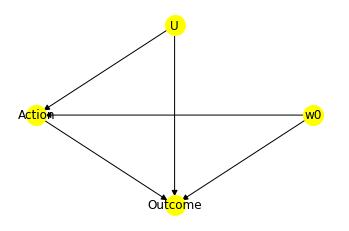

In [5]:
model= CausalModel(                                                                                                                      
        data=df,                                                                                                                         
        treatment=data_dict["treatment_name"],                                                                                           
        outcome=data_dict["outcome_name"],                                                                                               
        common_causes=data_dict["common_causes_names"],                                                                                  
        instruments=data_dict["instrument_names"])                                                                                       
model.view_model(layout="dot")                                                                                                                                                                                                                                             

Showing the causal model stored in the local file "causal_model.png"

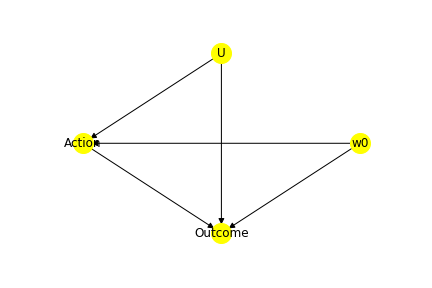

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### STEP 2: Identify causal effect using properties of the formal causal graph
Identify the causal effect using properties of the causal graph.

In [7]:
identified_estimand = model.identify_effect()
print(identified_estimand)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] 
Please respond with 'y' or 'n'
WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
    d                             
─────────(Expectation(Outcome|w0))
d[Action]                         
Estimand assumption 1, Unconfoundedness: If U→{Action} and U→Outcome then P(Outcome|Action,w0,U) = P(Outcome|Action,w0)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



### STEP 3: Estimate the causal effect

Once we have identified the estimand, we can use any statistical method to estimate the causal effect. 

Let's use Linear Regression for simplicity.

Causal Estimate is -0.006894154243713757


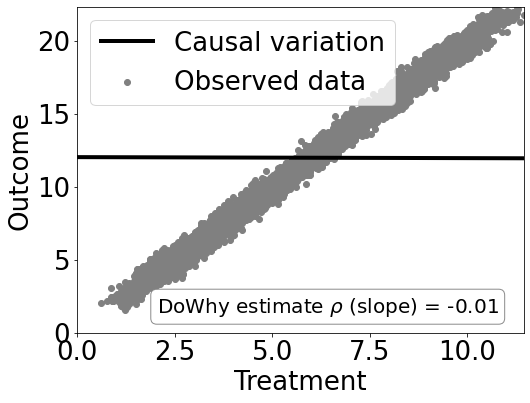

In [8]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect                                                                                                 
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

### Checking if the estimate is correct

In [9]:
print("DoWhy estimate is " + str(estimate.value)) 
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is -0.006894154243713757
Actual true causal effect was 0


### Step 4: Refuting the estimate

We can also refute the estimate to check its robustness to assumptions (*aka* sensitivity analysis, but on steroids). 

### Adding a random common cause variable

In [10]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:-0.006894154243713757
New effect:-0.006894216161146716



### Replacing treatment with a random (placebo) variable

In [11]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.006894154243713757
New effect:-3.093342225135132e-05
p value:0.49



### Removing a random subset of the data

In [12]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


Refute: Use a subset of data
Estimated effect:-0.006894154243713757
New effect:-0.006603332900408318
p value:0.48



As you can see, our causal estimator is robust to simple refutations.